In [13]:
import os
import time
import shelve
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
import matplotlib.pyplot as plt

In [14]:
def load_data(name):
    
    if name == 'mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif name == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        print('Only mnist or fashion_mnist.')
        return False
    
    imageSize  = X_train.shape[1]*X_train.shape[2]
    numClasses = np.max(y_train)+1

    X_train = np.reshape(X_train.astype(float)/255.0, (-1, 784))
    X_test  = np.reshape(X_test.astype(float)/255.0, (-1, 784))
    
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=numClasses)
    y_test  = tf.keras.utils.to_categorical(y_test, num_classes=numClasses)

    X_val   = X_train[-10000:]
    y_val   = y_train[-10000:]
    X_train = X_train[:-10000]
    y_train = y_train[:-10000]

    print('Data Split: ')
    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test : {X_test.shape }, y_test : {y_test.shape }')
    print(f'X_val  : {X_val.shape  }, y_val  : {y_val.shape  }')

    data = {}
    data['X_train'] = X_train
    data['y_train'] = y_train
    data['X_val']   = X_val
    data['y_val']   = y_val
    data['X_test']  = X_test
    data['y_test']  = y_test
    
    data['imageSize'] = imageSize
    
    return data

In [27]:
class MLP(object):
    
    def __init__(self, name, size_input, size_hidden, size_output, learning_rate=0.01, optimizer='SGD', weight_coeff=1,\
                 Reg=None, RegC=0, training=None, validation=None, accuracy=0, device=None):
       
        self.name          = name
        self.size_input    = size_input
        self.size_hidden   = size_hidden
        self.size_output   = size_output
        self.learning_rate = learning_rate
        self.optimizer     = optimizer
        self.Reg           = Reg
        self.RegC          = RegC
        self.training      = training
        self.validation    = validation
        self.accuracy      = accuracy
        self.device        = device
        self.weight_coeff  = weight_coeff
        
        self.W1 = self.initWeights(self.size_input, self.size_hidden[0], self.weight_coeff)
        self.b1 = self.initWeights(1, self.size_hidden[0], self.weight_coeff)
        
        self.W2 = self.initWeights(self.size_hidden[0], self.size_hidden[1], self.weight_coeff)
        self.b2 = self.initWeights(1, self.size_hidden[1], self.weight_coeff)
        
        self.W3 = self.initWeights(self.size_hidden[1], self.size_hidden[2], self.weight_coeff)
        self.b3 = self.initWeights(1, self.size_hidden[2], self.weight_coeff)
        
        self.W4 = self.initWeights(self.size_hidden[2], self.size_output, self.weight_coeff)
        self.b4 = self.initWeights(1, self.size_output, self.weight_coeff)
        
        self.varibles = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]
        
    
    def initWeights(self, rows, columns, multFactor=1):
        return tf.Variable(multFactor*tf.random.normal([rows, columns]))
    
    def forward(self, X):
        
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X)
        else:
            self.y = self.compute_output(X)
            
        return self.y
    
    def getRegLoss(self, X_train):
        
        if self.Reg=='L2':
            return (self.RegC/X_train.shape[0])*(tf.reduce_sum(tf.math.square(self.W1)) + 
                                                 tf.reduce_sum(tf.math.square(self.W2)) + 
                                                 tf.reduce_sum(tf.math.square(self.W3)) +
                                                 tf.reduce_sum(tf.math.square(self.W4)))
                
        elif self.Reg=='L1':
            return (self.RegC/X_train.shape[0])*tf.abs(tf.reduce_sum(self.W1) + 
                                                       tf.reduce_sum(self.W2) + 
                                                       tf.reduce_sum(self.W3) +
                                                       tf.reduce_sum(self.W4))
                
        elif self.Reg=='L1+L2':
            L2 =  (self.RegC/X_train.shape[0])*(tf.reduce_sum(tf.math.square(self.W1)) + 
                                                tf.reduce_sum(tf.math.square(self.W2)) + 
                                                tf.reduce_sum(tf.math.square(self.W3)) +
                                                tf.reduce_sum(tf.math.square(self.W4)))
                
            L1 = (self.RegC/X_train.shape[0])*tf.abs(tf.reduce_sum(self.W1) + 
                                                     tf.reduce_sum(self.W2) + 
                                                     tf.reduce_sum(self.W3) +
                                                     tf.reduce_sum(self.W4))
            return L1+L2
                
        else:
            return 0
        
    def loss(self, y_pred, y_true):
        
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        
        loss = tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
        return loss
    
    def backward(self, X_train, y_train):
        
        if self.optimizer=='SGD':
            optimizer = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
            
        elif self.optimizer=='Adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
            
        elif self.optimizer=='RMSprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
            
        else:
            pass 
            
        if self.Reg is not None and self.RegC==0:
            print('Regularization coffecient argument was O, seeting it to default lamda=0.01')
            self.RegC = 0.01;
            
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train)
            current_loss = self.loss(predicted, y_train)
            current_loss += self.getRegLoss(X_train)
  
        grads = tape.gradient(current_loss, self.varibles)
        optimizer.apply_gradients(zip(grads, self.varibles))
        
    def compute_output(self, X):
        
        X_tf = tf.cast(X, dtype=tf.float32)

        w1Hat = tf.matmul(X_tf,  self.W1) + self.b1
        h1Hat = tf.nn.relu(w1Hat)
        
        w2Hat = tf.matmul(h1Hat, self.W2) + self.b2
        h2Hat = tf.nn.relu(w2Hat)
        
        w3Hat = tf.matmul(h2Hat, self.W3) + self.b3
        h3Hat = tf.nn.relu(w3Hat)
        
        w4Hat = tf.matmul(h3Hat, self.W4) + self.b4
        output = tf.nn.softmax(w4Hat)
        
        return output
    
    def getAccuracy(self, predictions, outputs):
        preds  = np.argmax(predictions, axis=1)
        y_true = np.argmax(outputs, axis=1)

        return (preds==y_true).mean()

In [28]:
def trainModel(model, data, NUM_EPOCHS=10, batchSize=50, seedVal=1234):
    
    X_train = data['X_train'] 
    y_train = data['y_train']
    X_val   = data['X_val']
    y_val   = data['y_val']

    training = np.zeros(shape=(NUM_EPOCHS, 3))
    validation = np.zeros(shape=(NUM_EPOCHS, 3))

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batchSize)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batchSize)

    print(f'\n\n**************** Training model: {model.name} with optimizer: {model.optimizer} and seed: {seedVal} ****************\n')
    time_start = time.time()
    for epoch in range(NUM_EPOCHS):
        train_loss = tf.zeros([1, 1], dtype=tf.float32)
        val_loss   = tf.zeros([1, 1], dtype=tf.float32)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed = epoch*(seedVal)).batch(batchSize)
        val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(25, seed = epoch*(seedVal)).batch(batchSize)

        for inputs, outputs in train_ds:
            train_pred = model.forward(inputs)
            train_loss = train_loss + model.loss(train_pred, outputs)
            model.backward(inputs, outputs)
            train_acc = model.getAccuracy(train_pred, outputs)

        for inputs, outputs in val_ds:
            val_pred = model.forward(inputs)
            val_loss = val_loss + model.loss(val_pred, outputs)
            val_acc  = model.getAccuracy(val_pred, outputs)

        # train_loss = np.array(train_loss)
        # val_loss = np.array(val_loss)

        training[epoch] = [epoch+1, train_acc, np.sum(train_loss)/X_train.shape[0]]
        validation[epoch] = [epoch+1, val_acc, np.sum(train_loss)/X_train.shape[0]]

        print('# Epoch:={}/{}  - train loss:={:.4f} - val loss:={:.4f}, train acc:={:.2f} - val acc:={:.2f}'\
              .format(epoch+1, NUM_EPOCHS, np.sum(train_loss)/X_train.shape[0], np.sum(val_loss)/X_val.shape[0], train_acc, val_acc)) 

    time_taken = time.time()-time_start
    print(f'\nTotal time taken (in seconds): {time_taken: .2f}')
    print(f'\nFinished training model: {model.name}\n')
    model.training = training
    model.validation = validation

def testModel(model, data):
    
    X_test = data['X_test'] 
    y_test = data['y_test']
    
    preds = model.forward(X_test)
    
    pred = np.argmax(preds, axis=1)
    y_true= np.argmax(y_test, axis=1)

    model.accuracy = (pred==y_true).mean()*100
    
    print(f'**************** Testing ****************')
    print(f'{model.name} model accuracy = {model.accuracy:.2f}%')
    print(f'*****************************************')
    
def plotAccuracyAndLoss(model):
    
    training = model.training
    validation = model.validation
    fig, (ax1, ax2) = plt.subplots(1, 2)
    training[:, -1] = training[:, -1]/np.linalg.norm(training[:, -1]) 
    ax1.plot(training[:,0], training[:,1], 'g')
    ax1.plot(training[:,0], training[:,2], 'b')
    ax1.set_title('Training')
    ax1.legend(["Accuracy", "Loss"])

    validation[:, -1] = validation[:, -1]/np.linalg.norm(validation[:, -1]) 
    ax2.plot(validation[:,0], validation[:,1], 'g')
    ax2.plot(validation[:,0], validation[:,2], 'b')
    ax2.set_title('Validation')
    ax2.legend(["Accuracy", "Loss"])
    plt.show()

In [33]:
def main():
    
    for j in range(1):
        j=1
        if j==0:
            data = load_data('mnist')
            size_hidden = [128, 128, 128]
            learning_rate = 5e-4
            weight_coeff  = 1e-2
            
        if j==1:
            print('fashion_mnist is running')
            data = load_data('fashion_mnist')
            size_hidden = [1024, 512, 256]
            learning_rate = 5e-4
            weight_coeff  = 1e-3
            
        for k in range(1):
            if k==0:
                opt = 'RMSprop'
            elif k==1:
                opt = 'Adam'
            elif k==2:
                opt = 'SGD'
            else:
                pass
            
            imageSize = data['imageSize']

            size_input  = imageSize
            size_output = 10

            allModels = {}
            # allModels['mlp_on_gpu_default'] = {}
            allModels['mlp_on_gpu_RegL1']   = {}
            allModels['mlp_on_gpu_RegL2']   = {}  

            for model_name in allModels:
                model = allModels[model_name]

                cnt = -1

                numEpochs = 10
                batchSize = 50
                numTrials = 10

                seeds = random.sample(range(1000, 9999), numTrials)

                # loss     = np.zeros(shape=(numEpochs, 1))
                accuracy = np.zeros(shape=(numTrials, 1))

                for i in seeds:
                    cnt += 1

                    np.random.seed(i)
                    tf.random.set_seed(i)

                    print(f'Count: {cnt}, j=: {j}')
                    if model_name == 'mlp_on_gpu_default':
                        model['name'] = MLP('mlp_on_gpu_default', size_input, size_hidden, size_output, learning_rate, opt, weight_coeff,\
                                             device='gpu')

                    elif model_name == 'mlp_on_gpu_RegL1':
                        model['name'] = MLP('mlp_on_gpu_RegL1', size_input, size_hidden, size_output, learning_rate, opt, weight_coeff,\
                                            'L1', 1e-4, device='gpu')

                    elif model_name == 'mlp_on_gpu_RegL2':
                        model['name'] = MLP('mlp_on_gpu_RegL2', size_input, size_hidden, size_output, learning_rate, opt, weight_coeff,\
                                            'L2', 1e-4, device='gpu')

                    else:
                        pass

                    trainModel(model['name'], data, numEpochs, batchSize, i)
                    testModel(model['name'], data)

                    accuracy[cnt] = model['name'].accuracy

                    plotAccuracyAndLoss(model['name'])

                    allModels[model_name][i] = model['name']
                    allModels[model_name]['Accuracy'] = [np.mean(accuracy), np.var(accuracy)]

        if j==0:
            mnist = allModels
        elif j==1:
            fashion_mnist = allModels
        else:
            pass
        
    

    return mnist, fashion_mnist

fashion_mnist is running
Data Split: 
X_train: (50000, 784), y_train: (50000, 10)
X_test : (10000, 784), y_test : (10000, 10)
X_val  : (10000, 784), y_val  : (10000, 10)
Count: 0, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 2905 ****************

# Epoch:=1/10  - train loss:=0.0320 - val loss:=0.0314, train acc:=0.64 - val acc:=0.66
# Epoch:=2/10  - train loss:=0.0423 - val loss:=0.0543, train acc:=0.70 - val acc:=0.72
# Epoch:=3/10  - train loss:=0.0641 - val loss:=0.0594, train acc:=0.72 - val acc:=0.82
# Epoch:=4/10  - train loss:=0.0513 - val loss:=0.0314, train acc:=0.62 - val acc:=0.72
# Epoch:=5/10  - train loss:=0.0475 - val loss:=0.0925, train acc:=0.72 - val acc:=0.76
# Epoch:=6/10  - train loss:=0.0630 - val loss:=0.0539, train acc:=0.70 - val acc:=0.80
# Epoch:=7/10  - train loss:=0.0426 - val loss:=0.0464, train acc:=0.72 - val acc:=0.80
# Epoch:=8/10  - train loss:=0.0561 - val loss:=0.0413, train acc:=0.72 - val acc:=0.78
#

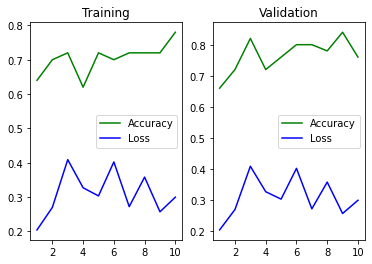

Count: 1, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 4555 ****************

# Epoch:=1/10  - train loss:=0.0317 - val loss:=0.0508, train acc:=0.70 - val acc:=0.64
# Epoch:=2/10  - train loss:=0.0542 - val loss:=0.0389, train acc:=0.78 - val acc:=0.64
# Epoch:=3/10  - train loss:=0.0681 - val loss:=0.0962, train acc:=0.78 - val acc:=0.58
# Epoch:=4/10  - train loss:=0.0467 - val loss:=0.0588, train acc:=0.68 - val acc:=0.78
# Epoch:=5/10  - train loss:=0.0507 - val loss:=0.0540, train acc:=0.64 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0477 - val loss:=0.0530, train acc:=0.74 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0443 - val loss:=0.0380, train acc:=0.74 - val acc:=0.88
# Epoch:=8/10  - train loss:=0.0477 - val loss:=0.0385, train acc:=0.80 - val acc:=0.76
# Epoch:=9/10  - train loss:=0.0435 - val loss:=0.0468, train acc:=0.74 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0516 - val loss:=0.0585, train acc:=0.74 - val acc:

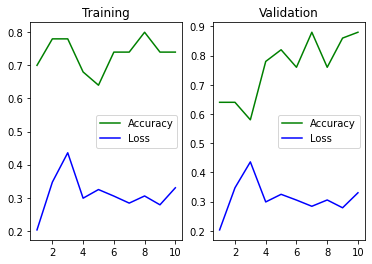

Count: 2, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 5904 ****************

# Epoch:=1/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.14 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:=0.08
# Epoch:=3/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.04 - val acc:=0.06
# Epoch:=4/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.14
# Epoch:=5/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.16
# Epoch:=6/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.12 - val acc:=0.12
# Epoch:=7/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.08
# Epoch:=8/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.10
# Epoch:=9/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.16
# Epoch:=10/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:

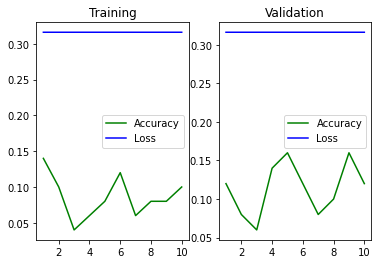

Count: 3, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 9699 ****************

# Epoch:=1/10  - train loss:=0.0213 - val loss:=0.0133, train acc:=0.68 - val acc:=0.80
# Epoch:=2/10  - train loss:=0.0272 - val loss:=0.0806, train acc:=0.66 - val acc:=0.58
# Epoch:=3/10  - train loss:=0.0391 - val loss:=0.0394, train acc:=0.78 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0353 - val loss:=0.0456, train acc:=0.76 - val acc:=0.76
# Epoch:=5/10  - train loss:=0.0324 - val loss:=0.0391, train acc:=0.74 - val acc:=0.76
# Epoch:=6/10  - train loss:=0.0439 - val loss:=0.0791, train acc:=0.68 - val acc:=0.68
# Epoch:=7/10  - train loss:=0.0574 - val loss:=0.0493, train acc:=0.76 - val acc:=0.78
# Epoch:=8/10  - train loss:=0.0518 - val loss:=0.0605, train acc:=0.72 - val acc:=0.72
# Epoch:=9/10  - train loss:=0.0450 - val loss:=0.0370, train acc:=0.74 - val acc:=0.82
# Epoch:=10/10  - train loss:=0.0345 - val loss:=0.0384, train acc:=0.80 - val acc:

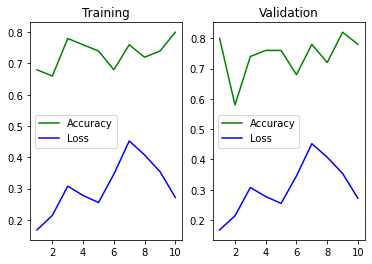

Count: 4, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 4396 ****************

# Epoch:=1/10  - train loss:=0.0338 - val loss:=0.0327, train acc:=0.66 - val acc:=0.54
# Epoch:=2/10  - train loss:=0.0321 - val loss:=0.0305, train acc:=0.72 - val acc:=0.64
# Epoch:=3/10  - train loss:=0.0421 - val loss:=0.1580, train acc:=0.68 - val acc:=0.42
# Epoch:=4/10  - train loss:=0.0663 - val loss:=0.1029, train acc:=0.64 - val acc:=0.54
# Epoch:=5/10  - train loss:=0.0418 - val loss:=0.0198, train acc:=0.70 - val acc:=0.72
# Epoch:=6/10  - train loss:=0.0373 - val loss:=0.0476, train acc:=0.74 - val acc:=0.72
# Epoch:=7/10  - train loss:=0.0476 - val loss:=0.0770, train acc:=0.72 - val acc:=0.72
# Epoch:=8/10  - train loss:=0.0502 - val loss:=0.0431, train acc:=0.74 - val acc:=0.76
# Epoch:=9/10  - train loss:=0.0366 - val loss:=0.0734, train acc:=0.78 - val acc:=0.78
# Epoch:=10/10  - train loss:=0.0606 - val loss:=0.0470, train acc:=0.76 - val acc:

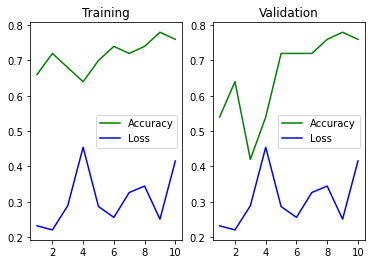

Count: 5, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 6036 ****************

# Epoch:=1/10  - train loss:=0.0304 - val loss:=0.0341, train acc:=0.68 - val acc:=0.72
# Epoch:=2/10  - train loss:=0.0510 - val loss:=0.0398, train acc:=0.68 - val acc:=0.72
# Epoch:=3/10  - train loss:=0.0661 - val loss:=0.0780, train acc:=0.64 - val acc:=0.78
# Epoch:=4/10  - train loss:=0.0850 - val loss:=0.0836, train acc:=0.70 - val acc:=0.62
# Epoch:=5/10  - train loss:=0.0776 - val loss:=0.0893, train acc:=0.74 - val acc:=0.76
# Epoch:=6/10  - train loss:=0.0548 - val loss:=0.0164, train acc:=0.78 - val acc:=0.70
# Epoch:=7/10  - train loss:=0.0330 - val loss:=0.0491, train acc:=0.80 - val acc:=0.78
# Epoch:=8/10  - train loss:=0.0524 - val loss:=0.0286, train acc:=0.78 - val acc:=0.78
# Epoch:=9/10  - train loss:=0.0464 - val loss:=0.0519, train acc:=0.86 - val acc:=0.88
# Epoch:=10/10  - train loss:=0.0614 - val loss:=0.0660, train acc:=0.74 - val acc:

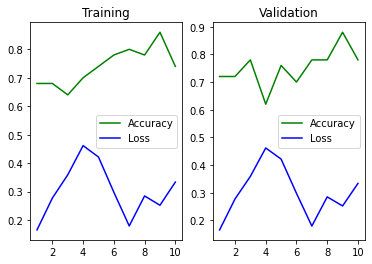

Count: 6, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 1330 ****************

# Epoch:=1/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.14
# Epoch:=2/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.04 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.12
# Epoch:=4/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.04
# Epoch:=5/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.16
# Epoch:=6/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.04 - val acc:=0.10
# Epoch:=7/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:=0.12
# Epoch:=8/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.06
# Epoch:=9/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.12 - val acc:=0.08
# Epoch:=10/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:

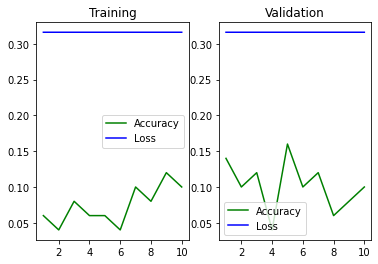

Count: 7, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 5606 ****************

# Epoch:=1/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.16
# Epoch:=3/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.10
# Epoch:=4/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.10
# Epoch:=5/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.14
# Epoch:=6/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:=0.12
# Epoch:=7/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.18
# Epoch:=8/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.16
# Epoch:=9/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.08
# Epoch:=10/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:

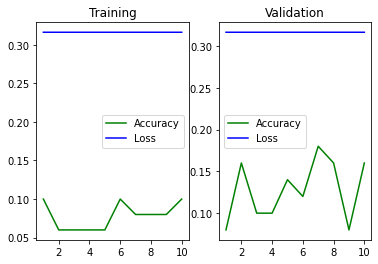

Count: 8, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 8743 ****************

# Epoch:=1/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.22
# Epoch:=3/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.16
# Epoch:=4/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.06 - val acc:=0.16
# Epoch:=5/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:=0.12
# Epoch:=6/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:=0.16
# Epoch:=7/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.12 - val acc:=0.12
# Epoch:=8/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.12 - val acc:=0.14
# Epoch:=9/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.10 - val acc:=0.12
# Epoch:=10/10  - train loss:=0.0461 - val loss:=0.0461, train acc:=0.08 - val acc:

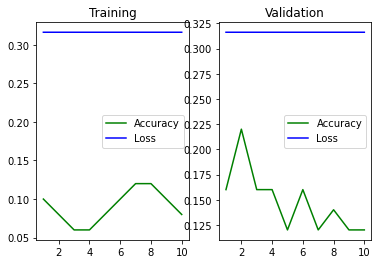

Count: 9, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with optimizer: RMSprop and seed: 7295 ****************

# Epoch:=1/10  - train loss:=0.0332 - val loss:=0.0335, train acc:=0.74 - val acc:=0.76
# Epoch:=2/10  - train loss:=0.0387 - val loss:=0.1121, train acc:=0.74 - val acc:=0.54
# Epoch:=3/10  - train loss:=0.0462 - val loss:=0.0531, train acc:=0.78 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0672 - val loss:=0.0679, train acc:=0.70 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0451 - val loss:=0.0454, train acc:=0.76 - val acc:=0.64
# Epoch:=6/10  - train loss:=0.0513 - val loss:=0.0220, train acc:=0.78 - val acc:=0.78
# Epoch:=7/10  - train loss:=0.0441 - val loss:=0.0515, train acc:=0.74 - val acc:=0.86
# Epoch:=8/10  - train loss:=0.0580 - val loss:=0.0711, train acc:=0.70 - val acc:=0.88
# Epoch:=9/10  - train loss:=0.0401 - val loss:=0.0649, train acc:=0.78 - val acc:=0.72
# Epoch:=10/10  - train loss:=0.0464 - val loss:=0.0475, train acc:=0.78 - val acc:

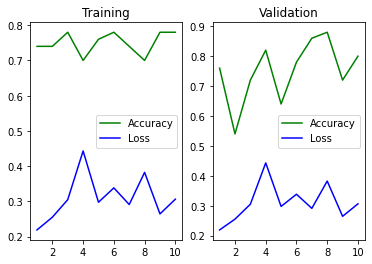

Count: 0, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 2906 ****************

# Epoch:=1/10  - train loss:=0.0246 - val loss:=0.0192, train acc:=0.68 - val acc:=0.68
# Epoch:=2/10  - train loss:=0.0247 - val loss:=0.0257, train acc:=0.70 - val acc:=0.80
# Epoch:=3/10  - train loss:=0.0281 - val loss:=0.0363, train acc:=0.76 - val acc:=0.66
# Epoch:=4/10  - train loss:=0.0375 - val loss:=0.0475, train acc:=0.74 - val acc:=0.70
# Epoch:=5/10  - train loss:=0.0211 - val loss:=0.0264, train acc:=0.74 - val acc:=0.66
# Epoch:=6/10  - train loss:=0.0192 - val loss:=0.0212, train acc:=0.72 - val acc:=0.74
# Epoch:=7/10  - train loss:=0.0205 - val loss:=0.0258, train acc:=0.74 - val acc:=0.74
# Epoch:=8/10  - train loss:=0.0260 - val loss:=0.0317, train acc:=0.74 - val acc:=0.66
# Epoch:=9/10  - train loss:=0.0232 - val loss:=0.0166, train acc:=0.62 - val acc:=0.72
# Epoch:=10/10  - train loss:=0.0184 - val loss:=0.0167, train acc:=0.76 - val acc:

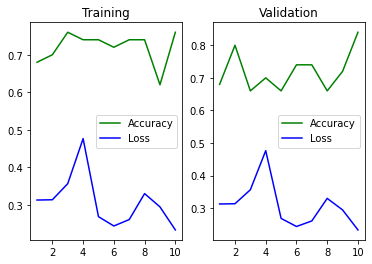

Count: 1, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 1922 ****************

# Epoch:=1/10  - train loss:=0.0303 - val loss:=0.0213, train acc:=0.64 - val acc:=0.66
# Epoch:=2/10  - train loss:=0.0285 - val loss:=0.0209, train acc:=0.72 - val acc:=0.62
# Epoch:=3/10  - train loss:=0.0275 - val loss:=0.0304, train acc:=0.72 - val acc:=0.70
# Epoch:=4/10  - train loss:=0.0238 - val loss:=0.0192, train acc:=0.54 - val acc:=0.80
# Epoch:=5/10  - train loss:=0.0231 - val loss:=0.0197, train acc:=0.62 - val acc:=0.76
# Epoch:=6/10  - train loss:=0.0245 - val loss:=0.0370, train acc:=0.70 - val acc:=0.66
# Epoch:=7/10  - train loss:=0.0217 - val loss:=0.0260, train acc:=0.76 - val acc:=0.70
# Epoch:=8/10  - train loss:=0.0223 - val loss:=0.0242, train acc:=0.74 - val acc:=0.68
# Epoch:=9/10  - train loss:=0.0252 - val loss:=0.0265, train acc:=0.80 - val acc:=0.74
# Epoch:=10/10  - train loss:=0.0201 - val loss:=0.0174, train acc:=0.64 - val acc:

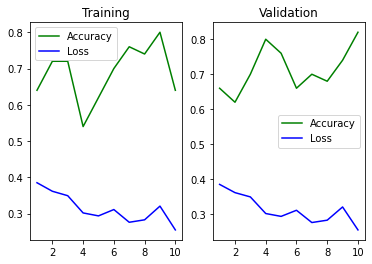

Count: 2, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 7996 ****************

# Epoch:=1/10  - train loss:=0.0259 - val loss:=0.0184, train acc:=0.68 - val acc:=0.68
# Epoch:=2/10  - train loss:=0.0195 - val loss:=0.0200, train acc:=0.72 - val acc:=0.70
# Epoch:=3/10  - train loss:=0.0249 - val loss:=0.0245, train acc:=0.66 - val acc:=0.84
# Epoch:=4/10  - train loss:=0.0234 - val loss:=0.0308, train acc:=0.82 - val acc:=0.64
# Epoch:=5/10  - train loss:=0.0310 - val loss:=0.0504, train acc:=0.76 - val acc:=0.64
# Epoch:=6/10  - train loss:=0.0274 - val loss:=0.0282, train acc:=0.70 - val acc:=0.72
# Epoch:=7/10  - train loss:=0.0195 - val loss:=0.0182, train acc:=0.74 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0202 - val loss:=0.0206, train acc:=0.78 - val acc:=0.74
# Epoch:=9/10  - train loss:=0.0219 - val loss:=0.0305, train acc:=0.84 - val acc:=0.78
# Epoch:=10/10  - train loss:=0.0197 - val loss:=0.0247, train acc:=0.80 - val acc:

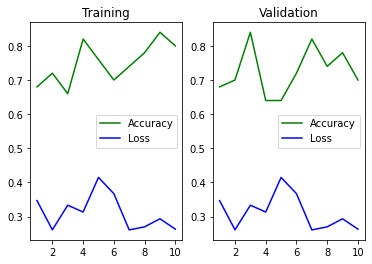

Count: 3, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 7909 ****************

# Epoch:=1/10  - train loss:=0.0229 - val loss:=0.0291, train acc:=0.78 - val acc:=0.62
# Epoch:=2/10  - train loss:=0.0252 - val loss:=0.0247, train acc:=0.68 - val acc:=0.66
# Epoch:=3/10  - train loss:=0.0345 - val loss:=0.0277, train acc:=0.80 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0269 - val loss:=0.0257, train acc:=0.54 - val acc:=0.74
# Epoch:=5/10  - train loss:=0.0250 - val loss:=0.0306, train acc:=0.72 - val acc:=0.80
# Epoch:=6/10  - train loss:=0.0218 - val loss:=0.0295, train acc:=0.72 - val acc:=0.70
# Epoch:=7/10  - train loss:=0.0264 - val loss:=0.0249, train acc:=0.76 - val acc:=0.72
# Epoch:=8/10  - train loss:=0.0299 - val loss:=0.0270, train acc:=0.76 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0208 - val loss:=0.0199, train acc:=0.84 - val acc:=0.70
# Epoch:=10/10  - train loss:=0.0184 - val loss:=0.0247, train acc:=0.74 - val acc:

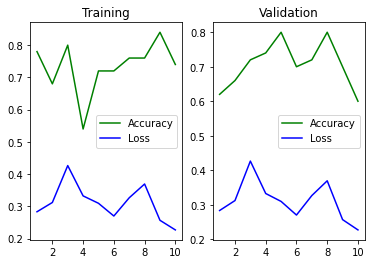

Count: 4, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 7417 ****************

# Epoch:=1/10  - train loss:=0.0242 - val loss:=0.0125, train acc:=0.66 - val acc:=0.82
# Epoch:=2/10  - train loss:=0.0203 - val loss:=0.0199, train acc:=0.60 - val acc:=0.70
# Epoch:=3/10  - train loss:=0.0223 - val loss:=0.0186, train acc:=0.70 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0251 - val loss:=0.0406, train acc:=0.72 - val acc:=0.68
# Epoch:=5/10  - train loss:=0.0484 - val loss:=0.0562, train acc:=0.74 - val acc:=0.74
# Epoch:=6/10  - train loss:=0.0488 - val loss:=0.0357, train acc:=0.72 - val acc:=0.68
# Epoch:=7/10  - train loss:=0.0221 - val loss:=0.0177, train acc:=0.78 - val acc:=0.74
# Epoch:=8/10  - train loss:=0.0185 - val loss:=0.0258, train acc:=0.72 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0238 - val loss:=0.0256, train acc:=0.74 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0280 - val loss:=0.0272, train acc:=0.76 - val acc:

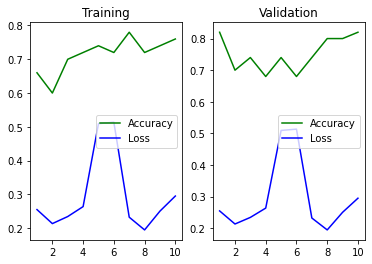

Count: 5, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 4884 ****************

# Epoch:=1/10  - train loss:=0.0243 - val loss:=0.0180, train acc:=0.66 - val acc:=0.66
# Epoch:=2/10  - train loss:=0.0248 - val loss:=0.0348, train acc:=0.76 - val acc:=0.62
# Epoch:=3/10  - train loss:=0.0253 - val loss:=0.0505, train acc:=0.76 - val acc:=0.64
# Epoch:=4/10  - train loss:=0.0418 - val loss:=0.0278, train acc:=0.72 - val acc:=0.68
# Epoch:=5/10  - train loss:=0.0199 - val loss:=0.0177, train acc:=0.80 - val acc:=0.74
# Epoch:=6/10  - train loss:=0.0193 - val loss:=0.0280, train acc:=0.80 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0209 - val loss:=0.0210, train acc:=0.78 - val acc:=0.70
# Epoch:=8/10  - train loss:=0.0193 - val loss:=0.0267, train acc:=0.74 - val acc:=0.64
# Epoch:=9/10  - train loss:=0.0223 - val loss:=0.0227, train acc:=0.78 - val acc:=0.78
# Epoch:=10/10  - train loss:=0.0167 - val loss:=0.0164, train acc:=0.76 - val acc:

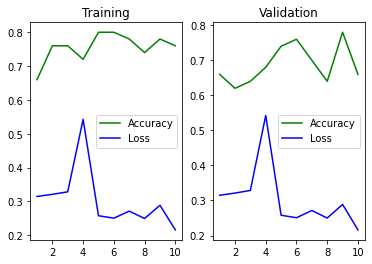

Count: 6, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 8755 ****************

# Epoch:=1/10  - train loss:=0.0233 - val loss:=0.0143, train acc:=0.78 - val acc:=0.80
# Epoch:=2/10  - train loss:=0.0227 - val loss:=0.0185, train acc:=0.68 - val acc:=0.84
# Epoch:=3/10  - train loss:=0.0282 - val loss:=0.0223, train acc:=0.78 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0245 - val loss:=0.0271, train acc:=0.72 - val acc:=0.76
# Epoch:=5/10  - train loss:=0.0259 - val loss:=0.0283, train acc:=0.70 - val acc:=0.76
# Epoch:=6/10  - train loss:=0.0274 - val loss:=0.0218, train acc:=0.68 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0214 - val loss:=0.0261, train acc:=0.74 - val acc:=0.68
# Epoch:=8/10  - train loss:=0.0199 - val loss:=0.0147, train acc:=0.80 - val acc:=0.86
# Epoch:=9/10  - train loss:=0.0210 - val loss:=0.0176, train acc:=0.74 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0196 - val loss:=0.0232, train acc:=0.68 - val acc:

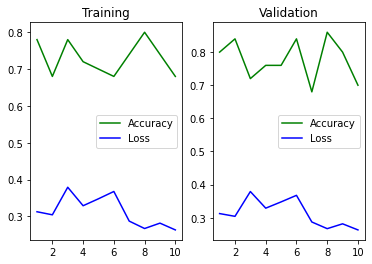

Count: 7, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 8529 ****************

# Epoch:=1/10  - train loss:=0.0238 - val loss:=0.0201, train acc:=0.70 - val acc:=0.64
# Epoch:=2/10  - train loss:=0.0236 - val loss:=0.0153, train acc:=0.58 - val acc:=0.84
# Epoch:=3/10  - train loss:=0.0304 - val loss:=0.0525, train acc:=0.74 - val acc:=0.66
# Epoch:=4/10  - train loss:=0.0417 - val loss:=0.0393, train acc:=0.72 - val acc:=0.62
# Epoch:=5/10  - train loss:=0.0254 - val loss:=0.0293, train acc:=0.80 - val acc:=0.66
# Epoch:=6/10  - train loss:=0.0220 - val loss:=0.0255, train acc:=0.58 - val acc:=0.74
# Epoch:=7/10  - train loss:=0.0259 - val loss:=0.0448, train acc:=0.72 - val acc:=0.74
# Epoch:=8/10  - train loss:=0.0424 - val loss:=0.0760, train acc:=0.74 - val acc:=0.70
# Epoch:=9/10  - train loss:=0.0335 - val loss:=0.0177, train acc:=0.78 - val acc:=0.76
# Epoch:=10/10  - train loss:=0.0187 - val loss:=0.0221, train acc:=0.76 - val acc:

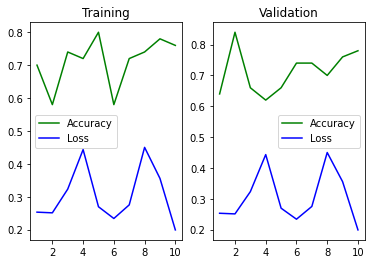

Count: 8, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 8111 ****************

# Epoch:=1/10  - train loss:=0.0256 - val loss:=0.0191, train acc:=0.66 - val acc:=0.62
# Epoch:=2/10  - train loss:=0.0205 - val loss:=0.0225, train acc:=0.68 - val acc:=0.64
# Epoch:=3/10  - train loss:=0.0223 - val loss:=0.0281, train acc:=0.66 - val acc:=0.60
# Epoch:=4/10  - train loss:=0.0235 - val loss:=0.0228, train acc:=0.78 - val acc:=0.64
# Epoch:=5/10  - train loss:=0.0235 - val loss:=0.0169, train acc:=0.60 - val acc:=0.78
# Epoch:=6/10  - train loss:=0.0210 - val loss:=0.0265, train acc:=0.78 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0220 - val loss:=0.0278, train acc:=0.76 - val acc:=0.60
# Epoch:=8/10  - train loss:=0.0266 - val loss:=0.0333, train acc:=0.70 - val acc:=0.74
# Epoch:=9/10  - train loss:=0.0264 - val loss:=0.0258, train acc:=0.74 - val acc:=0.78
# Epoch:=10/10  - train loss:=0.0212 - val loss:=0.0240, train acc:=0.72 - val acc:

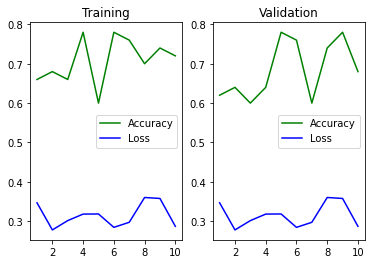

Count: 9, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with optimizer: RMSprop and seed: 9299 ****************

# Epoch:=1/10  - train loss:=0.0247 - val loss:=0.0196, train acc:=0.70 - val acc:=0.66
# Epoch:=2/10  - train loss:=0.0233 - val loss:=0.0222, train acc:=0.70 - val acc:=0.70
# Epoch:=3/10  - train loss:=0.0232 - val loss:=0.0298, train acc:=0.76 - val acc:=0.68
# Epoch:=4/10  - train loss:=0.0365 - val loss:=0.0334, train acc:=0.74 - val acc:=0.72
# Epoch:=5/10  - train loss:=0.0243 - val loss:=0.0173, train acc:=0.66 - val acc:=0.80
# Epoch:=6/10  - train loss:=0.0201 - val loss:=0.0239, train acc:=0.74 - val acc:=0.70
# Epoch:=7/10  - train loss:=0.0186 - val loss:=0.0163, train acc:=0.72 - val acc:=0.76
# Epoch:=8/10  - train loss:=0.0245 - val loss:=0.0605, train acc:=0.74 - val acc:=0.62
# Epoch:=9/10  - train loss:=0.0332 - val loss:=0.0525, train acc:=0.76 - val acc:=0.70
# Epoch:=10/10  - train loss:=0.0228 - val loss:=0.0232, train acc:=0.76 - val acc:

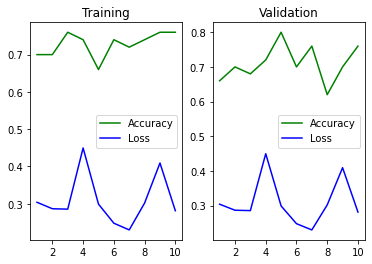

UnboundLocalError: local variable 'mnist' referenced before assignment

In [34]:
if __name__ == "__main__":
    mnist, fashion_mnist = main()